## A First Attempt at PAC in Spark

In [3]:
from pyspark.sql import SparkSession, DataFrame
from pyspark.sql.functions import lower, col, count, concat_ws
from pyspark.sql.types import Row
from pyspark import RDD
from typing import List, Tuple, Callable, Dict, Optional, Any, NamedTuple
import numpy as np
import scipy.stats as stats
from tqdm import tqdm

# from pacdb import PACDataFrame, Sampler, DataFrameSampler, SamplerOptions

spark = (SparkSession.builder.appName("pacdb")
         .config("spark.executor.memory", "512M")
         .config("spark.sql.warehouse.dir", ".spark")
         .enableHiveSupport()
         .getOrCreate())

spark.conf.set("spark.sql.execution.arrow.pyspark.enabled", "true")

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import matplotlib.lines as mlines
import matplotlib.patches as mpatches

# set font to Times New Roman
LATEX = False
if LATEX:
    mpl.rcParams['text.usetex'] = True
    mpl.rcParams["font.family"] = "serif"
    mpl.rcParams["font.serif"] = "Times"
else:
    mpl.rcParams['text.usetex'] = False
    mpl.rcParams["font.family"] = "Times New Roman"

plt.rcParams['svg.fonttype'] = 'none'
mpl.rcParams['savefig.dpi'] = 300

import matplotlib_inline.backend_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')

mpl.rcParams['axes.titleweight'] = 'bold'

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/03/06 14:33:52 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [3]:
# Non-private query

lung_df = spark.read.parquet("./data/lung.parquet")
#lung_df.write.saveAsTable("lung", mode="overwrite") # for SQL queries

smokers = lung_df.filter(lung_df["Smoking"] >= 3) # Smoking is on 1-7 scale
smokers.count()

597

In [14]:
from pacdb import PACDataFrame, Sampler, DataFrameSampler, SamplerOptions

# created a new PACDataFrame object
pac_lung_df = (PACDataFrame(lung_df)
                .withSamplerOptions(
                    SamplerOptions(
                        withReplacement=False, # default value for pyspark.sql.DataFrame.sample
                        fraction=0.5
                    )
                ))

pac_lung_df.sample().toPandas().head()

del pac_lung_df

# paclib.sample_proportionately(lung_df, ["Gender","Smoking"], 0.1).toPandas().head()

### Sampling

Spark provides two functions for sampling out of a dataset. `sample` selects a chosen percentage of the dataset. `sampleBy` allows to further specify the distribution of the sample.

See `sample_proportionately` in `paclib/main.py` for my attempt at reproducing the sampling strategy from the PAC-ML code.

Here I use `sample` directly as we are only querying one one-dimensional variable.

In [18]:
df = lung_df
trials = 200 * 2
sampling_rate = 0.5

n = df.count()

samples = []

pac_lung_df = (PACDataFrame(lung_df)
                .withSamplerOptions(
                    SamplerOptions(
                        withReplacement=False, 
                        fraction=0.5
                    )
                ))

for i in tqdm(range(trials)):
    s = (pac_lung_df.sample()
         .filter(lung_df["Smoking"] >= 3)  # run query on sample
         .count())
    samples.append(s)  # store result of query

samples = [s * (1/sampling_rate) for s in samples]  # so that counts are not halved

100%|██████████| 400/400 [00:32<00:00, 12.34it/s]


These are the samples that we have:

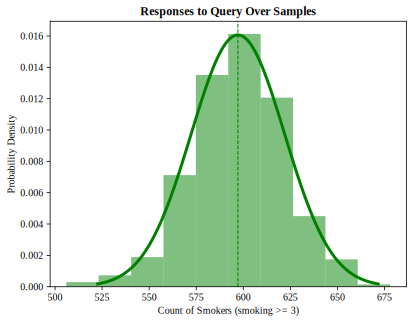

In [19]:
plt.hist(samples, bins=10, density=True, alpha=0.5, color='g')

mu = np.mean(samples)
sigma = np.std(samples)
x = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)
plt.plot(x, stats.norm.pdf(x, mu, sigma), color='g', linewidth=3)

# highlight mean
plt.axvline(mu, color='g', linestyle='dashed', linewidth=1)
# label
#plt.text(mu+17, 0.0117, f'$\mu={mu:.2f}$', ha='center', va='top', fontsize=8)

# label the axes
plt.title('Responses to Query Over Samples')
plt.xlabel('Count of Smokers (smoking >= 3)')
plt.ylabel('Probability Density')
plt.savefig("figs/samples.png")

In [41]:
{'mean': mu, 'variance': sigma**2, 'covariance': np.cov(samples, samples)}

{'mean': 597.12,
 'variance': 616.2456,
 'covariance': array([[617.79007519, 617.79007519],
        [617.79007519, 617.79007519]])}

(We use variance as the 1D equivalent of covariance.)

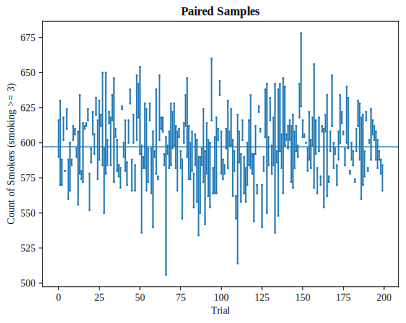

In [54]:
sample_pairs = list(zip(samples[::2], samples[1::2]))

# plot first points
plt.scatter(range(len(sample_pairs)), [sp[0] for sp in sample_pairs], alpha=1, color='tab:blue', s=1)
# plot second points
plt.scatter(range(len(sample_pairs)), [sp[1] for sp in sample_pairs], alpha=1, color='tab:blue', s=1)
# draw a vertical line from sp[0] to sp[1] for each pair
for i, sp in enumerate(sample_pairs):
    plt.plot([i, i], [sp[0], sp[1]], color='tab:blue', alpha=1)


# depict mean as a line
plt.axhline(y=np.mean(samples), color='tab:blue', linestyle='-', lw=1)

plt.title('Paired Samples')
plt.xlabel('Trial')
plt.ylabel('Count of Smokers (smoking >= 3)')
# min y axis must be 0
#plt.ylim(bottom=0)
plt.savefig("figs/variance.png")

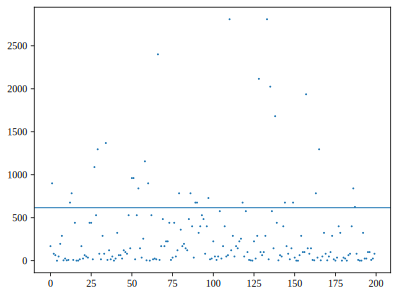

In [56]:
# plot variance of paired samples
plt.scatter(range(len(sample_pairs)), [np.var(sp) for sp in sample_pairs], alpha=1, color='tab:blue', s=1)
plt.axhline(y=np.var(samples), color='tab:blue', linestyle='-', lw=1)

### Noise

Now we calculate the noise to add. I've attempted to construct what I need based on the PAC-ML code, but this probably has many errors.

I am using the following for the variance of the noise, taken from the end of PAC-ML's `rand_mechanism_noise` (but it is mostly a guess as I am unsure about what some of that code does):
$$ ((\text{avg\_dist} + c) / (2*(\text{max\_mi} / 2.))) $$

In [128]:
import paclib
import paclib.mechanism

c = 0.001
max_mi = 1/32

# find paired distances
dists = [np.abs(sp[0] - sp[1]) for sp in sample_pairs]
avg_dist = np.mean(dists)

# At different levels of MI, compute noise to add?
noise_params = []
for max_mi in [1/64, 1/32, 1/16, 1/8, 1/4, 1/2, 1., 2., 4.]:
    print(f"avg_dist: {avg_dist}, c: {c}, max_mi: {max_mi:8} => {paclib.mechanism.noise_to_add_parameters(avg_dist, c, max_mi)}")
    noise_params.append([max_mi, paclib.mechanism.noise_to_add_parameters(avg_dist, c, max_mi).mean, paclib.mechanism.noise_to_add_parameters(avg_dist, c, max_mi).variance])

avg_dist: 26.98, c: 0.001, max_mi: 0.015625 => GaussianDistribution(mean=0, variance=1726.784)
avg_dist: 26.98, c: 0.001, max_mi:  0.03125 => GaussianDistribution(mean=0, variance=863.392)
avg_dist: 26.98, c: 0.001, max_mi:   0.0625 => GaussianDistribution(mean=0, variance=431.696)
avg_dist: 26.98, c: 0.001, max_mi:    0.125 => GaussianDistribution(mean=0, variance=215.848)
avg_dist: 26.98, c: 0.001, max_mi:     0.25 => GaussianDistribution(mean=0, variance=107.924)
avg_dist: 26.98, c: 0.001, max_mi:      0.5 => GaussianDistribution(mean=0, variance=53.962)
avg_dist: 26.98, c: 0.001, max_mi:      1.0 => GaussianDistribution(mean=0, variance=26.981)
avg_dist: 26.98, c: 0.001, max_mi:      2.0 => GaussianDistribution(mean=0, variance=13.4905)
avg_dist: 26.98, c: 0.001, max_mi:      4.0 => GaussianDistribution(mean=0, variance=6.74525)


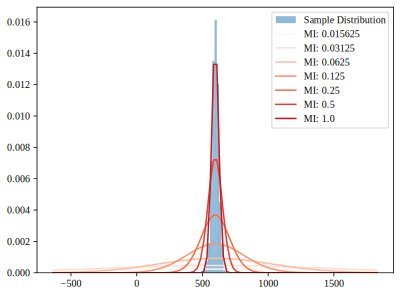

In [145]:
# plot original sample distribution
plt.hist(samples, bins=10, density=True, alpha=0.5, color='tab:blue', label="Sample Distribution")

sm = np.mean(samples)
sv = np.var(samples)

# colors = reds
colors = plt.cm.Reds(np.linspace(0, 1, len(noise_params)))
color_i = 0
def next_color():
    global color_i
    c = colors[color_i]
    color_i += 1
    return c

# for each mi, plot the normal distribution centered at mean with variance. have mis as legend
for max_mi, mean, variance in noise_params[:7]:
    mean = sm
    x = np.linspace(mean - 2*sv, mean + 2*sv, 100)
    plt.plot(x, stats.norm.pdf(x, mean, variance), label=f"MI: {max_mi}", color=next_color())

plt.legend()


In [39]:
# obtain one more sample to use for noised release
s = (pac_lung_df.sample()
     .filter(lung_df["Smoking"] >= 3)  # run query on sample
     .count())

mi = 1/32
noise_to_add = paclib.mechanism.noise_to_add(avg_dist, c, mi)

noised_s = s + noise_to_add

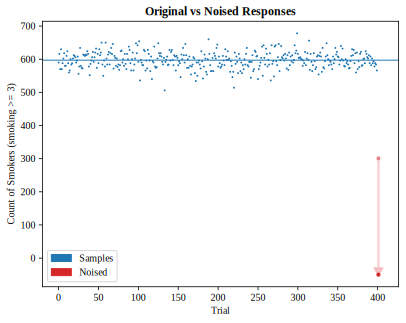

In [75]:
# plot samples
plt.scatter(range(len(samples)), samples, alpha=1, color='tab:blue', s=1)
plt.axhline(y=np.mean(samples), color='tab:blue', linestyle='-', lw=1)

# plot noised response
plt.scatter([len(samples)+1], [s], alpha=0.4, color='tab:red', s=10)
plt.scatter([len(samples)+1], [noised_s], alpha=1, color='tab:red', s=10)
# plot arrow from sample to noised response
plt.arrow(len(samples)+1, s, 0, noised_s-s, color='tab:red', alpha=0.2, length_includes_head=True, head_width=10, head_length=20, lw=2.5)

plt.title('Original vs Noised Responses')
plt.xlabel('Trial')
plt.ylabel('Count of Smokers (smoking >= 3)')
plt.legend(handles=[mpatches.Patch(color='tab:blue', label='Samples'), mpatches.Patch(color='tab:red', label='Noised')])
#plt.ylim(bottom=0)
plt.savefig("figs/original-vs-noised.png")

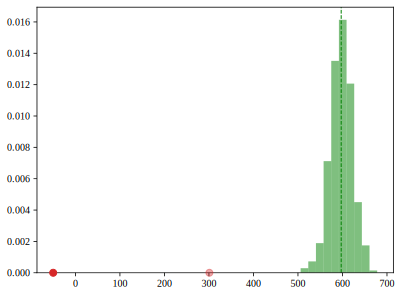

In [82]:
# plot noised response on original distribution
plt.hist(samples, bins=10, density=True, alpha=0.5, color='g')
plt.axvline(mu, color='g', linestyle='dashed', linewidth=1)

plt.scatter([s], [0], alpha=0.4, color='tab:red', s=50, zorder=10, clip_on=False)
plt.scatter([noised_s], [0], alpha=1, color='tab:red', s=50, zorder=10, clip_on=False)

### Multiple Tables

In [16]:
# Split the lung table into multiple tables over Patient Id
identity_df: DataFrame = lung_df.select("Name", "index", "Patient Id", "Age", "Gender")
identity_df.write.saveAsTable("identity", mode="overwrite")

symptoms_df: DataFrame = lung_df.select("Patient Id", "Chest Pain", "Coughing of Blood", "Fatigue", "Weight Loss", "Shortness of Breath", "Wheezing", "Swallowing Difficulty", "Clubbing of Finger Nails", "Frequent Cold", "Dry Cough", "Snoring")
symptoms_df.write.saveAsTable("symptoms", mode="overwrite")

risk_factors_df: DataFrame = lung_df.select("Patient Id", "Air Pollution", "Alcohol use", "Dust Allergy", "Occupational Hazards", "Genetic Risk", "Chronic Lung Disease", "Balanced Diet", "Obesity", "Smoking", "Passive Smoker")
risk_factors_df.write.saveAsTable("risk_factors", mode="overwrite")

In [17]:
# Count the number of patients in each age group with chest pain who are smokers
spark.sql("""
        SELECT FLOOR(identity.Age / 10) * 10 AS Age_Group, COUNT(*) AS Count
        FROM identity
        JOIN symptoms ON identity.`Patient Id` = symptoms.`Patient Id`
        JOIN risk_factors ON identity.`Patient Id` = risk_factors.`Patient Id`
        WHERE risk_factors.Smoking >= 3
          AND symptoms.`Chest Pain` > 1
        GROUP BY FLOOR(identity.Age / 10) * 10
        ORDER BY Age_Group
        """).toPandas()

,Age_Group,Count
0,10,28
1,20,106
2,30,222
3,40,120
4,50,30
5,60,31
6,70,10


In [18]:
df: DataFrame = (identity_df.join(symptoms_df, "Patient Id") # First do all the joins
                 .join(risk_factors_df, "Patient Id"))
df.count()

1000

In [25]:
(identity_df.join(symptoms_df, "Patient Id") # First do all the joins
        .join(risk_factors_df, "Patient Id")
        .df.filter(df["Smoking"] >= 3)  # N
        .filter(df["Chest Pain"] > 1)
        .withColumn("Age_Group", (df["Age"] / 10).cast("int") * 10)
        .groupBy("Age_Group")
        .count()
        .orderBy("Age_Group")).show()

AttributeError: 'DataFrame' object has no attribute 'df'

In [19]:
# Subsample --> DBi

# Run M(DBi)
(df.filter(df["Smoking"] >= 3)  # N
         .filter(df["Chest Pain"] > 1)
         .withColumn("Age_Group", (df["Age"] / 10).cast("int") * 10)
         .groupBy("Age_Group")
         .count()
         .orderBy("Age_Group")).show()

# --> Covariance matrix
# interact with PAC library
# --> Noise
# PAC library

# Noised release of M(DBn+1) + noise

+---------+-----+
|Age_Group|count|
+---------+-----+
|       10|   28|
|       20|  106|
|       30|  222|
|       40|  120|
|       50|   30|
|       60|   31|
|       70|   10|
+---------+-----+



In [20]:
df: DataFrame = (identity_df.join(symptoms_df, "Patient Id")
                 .join(risk_factors_df, "Patient Id"))

trials = 200
sampling_rate = 0.5

n = df.count()

samples = []
for i in range(trials):
    s = (df.sample(fraction=0.5, withReplacement=True)  # 50% sampling rate
         .filter(df["Smoking"] >= 3)
         .filter(df["Chest Pain"] > 1)
         .withColumn("Age_Group", (df["Age"] / 10).cast("int") * 10)
         .groupBy("Age_Group")
         .count()
         .orderBy("Age_Group"))
    samples.append(s)  # store result of query

#samples = [s * (1/sampling_rate) for s in samples]  # so that counts are not halved

In [21]:
# samples is a list of DataFrames, convert to a Spark type
samples_rdd: RDD = spark.sparkContext.parallelize(samples)

Traceback (most recent call last):
  File "/opt/homebrew/lib/python3.11/site-packages/pyspark/serializers.py", line 459, in dumps
    return cloudpickle.dumps(obj, pickle_protocol)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/homebrew/lib/python3.11/site-packages/pyspark/cloudpickle/cloudpickle_fast.py", line 73, in dumps
    cp.dump(obj)
  File "/opt/homebrew/lib/python3.11/site-packages/pyspark/cloudpickle/cloudpickle_fast.py", line 632, in dump
    return Pickler.dump(self, obj)
           ^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/homebrew/lib/python3.11/site-packages/pyspark/context.py", line 466, in __getnewargs__
    raise PySparkRuntimeError(
pyspark.errors.exceptions.base.PySparkRuntimeError: [CONTEXT_ONLY_VALID_ON_DRIVER] It appears that you are attempting to reference SparkContext from a broadcast variable, action, or transformation. SparkContext can only be used on the driver, not in code that it run on workers. For more information, see SPARK-5063.


PicklingError: Could not serialize object: PySparkRuntimeError: [CONTEXT_ONLY_VALID_ON_DRIVER] It appears that you are attempting to reference SparkContext from a broadcast variable, action, or transformation. SparkContext can only be used on the driver, not in code that it run on workers. For more information, see SPARK-5063.